In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import collections 
import time
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
def load_np_array(file_name):
    X_array = np.load('data/X_' + file_name + '_array.npy')
    y_array = np.load('data/y_' + file_name + '_array.npy')
    return X_array, y_array

X_train_fall, y_train_fall = load_np_array("train_fall")
X_train_notfall, y_train_notfall = load_np_array("train_notfall")
X_test_fall, y_test_fall = load_np_array("test_fall")
X_test_notfall, y_test_notfall = load_np_array("test_notfall")

In [3]:
print(X_train_fall.shape)
print(y_train_fall.shape)
print(X_train_notfall.shape)
print(y_train_notfall.shape)

(2912, 40, 3)
(2912,)
(2912, 40, 3)
(2912,)


In [4]:
print(X_test_fall.shape)
print(y_test_fall.shape)
print(X_test_notfall.shape)
print(y_test_notfall.shape)

(1456, 40, 3)
(1456,)
(1456, 40, 3)
(1456,)


In [5]:
y_test_fall

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [6]:
import numpy as np

# Combine fall and non-fall data for training
X_train = np.concatenate((X_train_fall, X_train_notfall), axis=0)
y_train = np.concatenate((y_train_fall, y_train_notfall), axis=0)

# Combine fall and non-fall data for testing
X_test = np.concatenate((X_test_fall, X_test_notfall), axis=0)
y_test = np.concatenate((y_test_fall, y_test_notfall), axis=0)

# Shuffle the training data
train_indices = np.arange(X_train.shape[0])
np.random.shuffle(train_indices)
X_train = X_train[train_indices]
y_train = y_train[train_indices]

# Shuffle the testing data
test_indices = np.arange(X_test.shape[0])
np.random.shuffle(test_indices)
X_test = X_test[test_indices]
y_test = y_test[test_indices]

print("Combined training data shape:", X_train.shape, y_train.shape)
print("Combined testing data shape:", X_test.shape, y_test.shape)


Combined training data shape: (5824, 40, 3) (5824,)
Combined testing data shape: (2912, 40, 3) (2912,)


In [7]:
# Shuffle the training data
train_indices = np.arange(X_train.shape[0])
np.random.shuffle(train_indices)
X_train = X_train[train_indices]
y_train = y_train[train_indices]

# Shuffle the testing data
test_indices = np.arange(X_test.shape[0])
np.random.shuffle(test_indices)
X_test = X_test[test_indices]
y_test = y_test[test_indices]

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the GRU model
model = Sequential()
model.add(GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(GRU(32))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 40, 64)            13248     
                                                                 
 dropout (Dropout)           (None, 40, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 22689 (88.63 KB)
Trainable params: 22689 (88.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
182/182 [==============================] - 13s 43ms/step - loss: 0.4955 - accuracy: 0.7809 - val_loss: 0.2068 - val_accuracy: 0.9303
Epoch 2/10
182/182 [==============================] - 7s 37ms/step - loss: 0.2036 - accuracy: 0.9258 - val_loss: 0.1166 - val_accuracy: 0.9557
Epoch 3/10
182/182 [==============================] - 7s 38ms/step - loss: 0.1445 - accuracy: 0.9485 - val_loss: 0.1007 - val_accuracy: 0.9674
Epoch 4/10
182/182 [==============================] - 7s 36ms/step - loss: 0.1132 - accuracy: 0.9583 - val_loss: 0.0934 - val_accuracy: 0.9708
Epoch 5/10
182/182 [==============================] - 7s 37ms/step - loss: 0.1069 - accuracy: 0.9653 - val_loss: 0.0835 - val_accuracy: 0.9694
Epoch 6/10
182/182 [==============================] - 8s 44ms/step - loss: 0.0862 - accuracy: 0.9730 - val_loss: 0.1015 - val_accuracy: 0.9677
Epoch 7/10
182/182 [==============================] - 7s 38ms/step - loss: 0.0811 - accuracy: 0.9734 - val_loss: 0.0876 - val_accuracy: 0.968

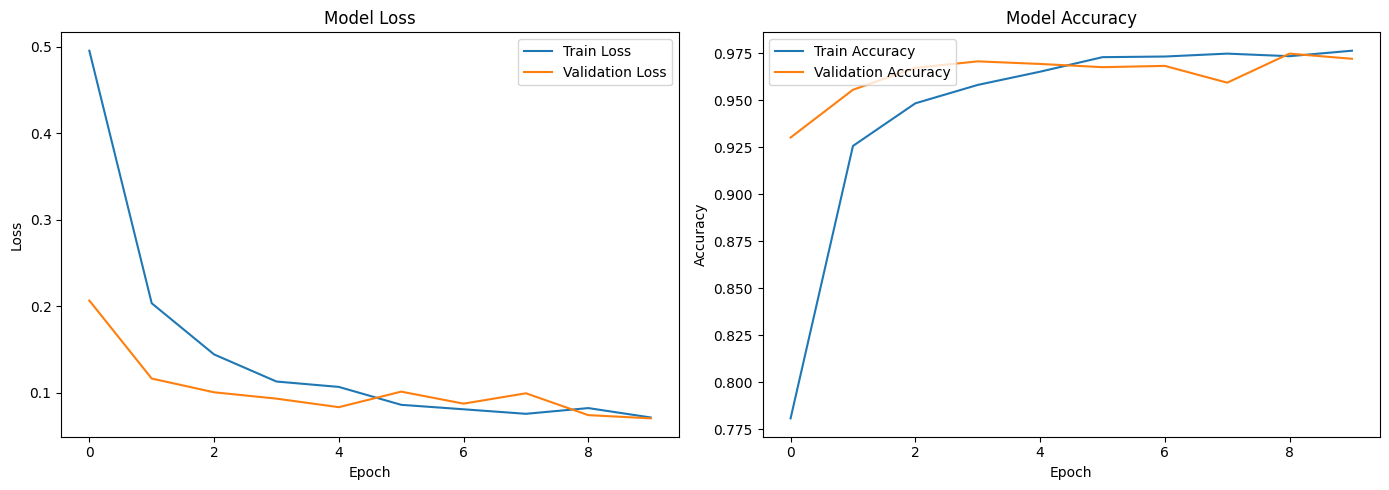

In [10]:
# Plot training & validation loss values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [11]:
# Predict on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

91/91 [==============================] - 2s 14ms/step
Accuracy: 0.9722
Precision: 0.9599
Recall: 0.9856
F1 Score: 0.9726


In [12]:
y_test

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Generate and print classification report
report = classification_report(y_test, y_pred, target_names=['Not Fall', 'Fall'])
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

    Not Fall       0.99      0.96      0.97      1456
        Fall       0.96      0.99      0.97      1456

    accuracy                           0.97      2912
   macro avg       0.97      0.97      0.97      2912
weighted avg       0.97      0.97      0.97      2912



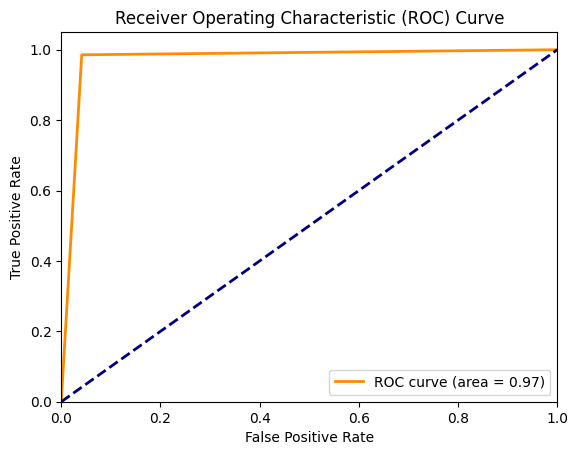

AUC: 0.9722


In [16]:
from sklearn.metrics import roc_curve, auc

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc:.4f}")